# Notebook 03: Simulation of Acetogenic Fermentation in Bubble Column at 30 and 60°C

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

This notebook simulates the fermentation of acetogenic growth in a large scale bubble column reactor at two given temperatures, using mass balances as defined in notebook 01, and a thermodynaminc-based black box model of acetogenic growth, building on notebook 02.

Notebook author: Philip J. Gorter de Vries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define parameters

In [2]:
Tc1 = 30 #Temperature in Celsius
Tc2 = 60 #Temperature in Celsius

SameGrowthRates = False #For the sake of comparisson, the maximum growth rates can be forced to be equal. Otherwise, they are temperature dependant 

#Reaction time
t_rt = 500 # [h]
t_rt = t_rt*3600 # [s]
inoc = 1

#Universal constants:
R = 8.314 # [m^3*Pa/K/mol]

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

T1 = Celsius_Kelvin(Tc1)
T2 = Celsius_Kelvin(Tc2)
t = np.linspace(0,t_rt,1000)

## Bubble column setup parameters:

In [3]:
v_gas = 0.3 # average gas velocity [m/s]
h_r = 30 # height of the reactor [m]
ar = 5 # aspect ratio: height to diameter

In [4]:
r = h_r/(ar * 2)
h = 2/3 * h_r # initial height of broth  assuming it is 2/3 filled [m]
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h #reactor volume [m^3]
F_G = v_gas * A
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

h,r,A,V_L,V_G,F_G

(20.0,
 3.0,
 28.274333882308138,
 565.4866776461628,
 146.06915149392105,
 8.482300164692441)

In [5]:
# Gas feed composition, CO2/H2 ratio, from notebook 2.5, adding 0.5 mol/mol N2 as a driver gas

r_co2h2_T1 = (1-0.89)/0.89
r_co2h2_T2 = (1-0.84)/0.84

In [6]:
#Gas feed composition at T1
y_co2_T1 = r_co2h2_T1/(1 + r_co2h2_T1)
y_h2_T1 = (1 - r_co2h2_T1/(1 + r_co2h2_T1))
y_n2_T1 = 0.01

cG_co2_in_T1 = y_co2_T1 * p_m/(R*T1)
cG_h2_in_T1 = y_h2_T1 * p_m/(R*T1)
cG_n2_in_T1 = y_n2_T1 * p_m/(R*T1)

#Gas feed composition at T2
y_co2_T2 = r_co2h2_T2/(1 + r_co2h2_T2)
y_h2_T2 = (1 - r_co2h2_T2/(1 + r_co2h2_T2))
y_n2_T2 = 0.01

cG_co2_in_T2 = y_co2_T2 * p_m/(R*T1)
cG_h2_in_T2 = y_h2_T2 * p_m/(R*T1)
cG_n2_in_T2 = y_n2_T2 * p_m/(R*T1)

# Biological Parameters

In [7]:
# for details, view 02_AcetogenYieldTempDependency.ipynb

def µ_max(T):
    if SameGrowthRates == True:
        return 0.4/3600 #[/s]
    else:
        return 46.35 * T * np.exp(-28127.1/(R*T))/3600 #[/s]

def m_NGAM(T):
    return 3.3**(69000/R*(1/298-1/T))/3600 #[kJ/s/CmolX]

m_GAM = 1000 #kJ/CmolX

# Monod substrate saturation constants and inhibtion parameters:
Ks_h2 =  0.0002950 # [mM] https://doi.org/10.1016/j.jece.2022.107281
Ks_co2 =  0.0002950 # [mM] taken from H2
Ki_actt = 800 #mM Inhibition constant for acetone

print(f"at Temperature = {Tc1}°C")
print(f"m_NGAM = {round(m_NGAM(T1),5)} [kJ/s/CmolX]")
print(f"µ_max = {round(µ_max(T1),5)} [/s]")
print(f"m_GAM = {m_GAM} [kJ/CmolX] \n")

print(f"at Temperature = {Tc2}°C")
print(f"m_NGAM = {round(m_NGAM(T2),5)} [kJ/s/CmolX]")
print(f"µ_max = {round(µ_max(T2),5)} [/s]")
print(f"m_GAM = {m_GAM} [kJ/CmolX]")

at Temperature = 30°C
m_NGAM = 0.00049 [kJ/s/CmolX]
µ_max = 6e-05 [/s]
m_GAM = 1000 [kJ/CmolX] 

at Temperature = 60°C
m_NGAM = 0.00927 [kJ/s/CmolX]
µ_max = 0.00017 [/s]
m_GAM = 1000 [kJ/CmolX]


# Calculate Gibbs free energy and Enthalpy of Catabolic reaction

<p>Given the reaction stoichiometries:</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>

In [8]:
S = pd.DataFrame({
    'Cata':  [-4,  0,    -2,  2,    0,1],
    'Ana':   [-2.1, -0.2, -1,  1.5,  1,0]},
    index=pd.Index(["H2","NH3","CO2","Water","X","Acetate"]))

S

,Cata,Ana
H2,-4,-2.1
NH3,0,-0.2
CO2,-2,-1.0
Water,2,1.5
X,0,1.0
Acetate,1,0.0


In [9]:
dfGR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfGR"]
dfHR = pd.read_csv("../Data/EnthalpyGibbs.csv", index_col="Compound")["dfHR"]

#Hess's law, as vector multiplication:
DrGR = np.nansum(S.Cata * dfGR)
DrHR = np.nansum(S.Cata * dfHR)

#Gibbs–Helmholtz equation for temperature correction
def DrGT(T):
    return DrGR * (T/298.15) + DrHR * (1-T/298.15)

print("DrGT at 30°C: ",DrGT(T1))
print("DrGT at 60°C: ",DrGT(T2))

DrGT at 30°C:  -150.81437699144723
DrGT at 60°C:  -140.6406389401308


# Determine anabolic reaction and balance reactions including GAM

<p>Catabolic reaction stoichiometries:</p>

<p>$ 2 CO_2 + 4 H_2 <=> CH_3COOH + 2 H_2O $ 
    <span style="float:right;">(eq. 19)</span> </p>

<p>Anabolic reaction stoichiometries: With an apporximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>$ -r_{CO2} CO_2 - r_{H} H_2 - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{W} H_2O = 0$ </p>

Which results in:

<p>$ CO_2 + 2.1 H_2 + 0.2 NH_3 <=> CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O$
    <span style="float:right;">(eq. 21)</span>  </p>
    
With the corrected Gibbs energy of reaction and the the growth-associated maintenance requirement being determined, the next step is to express the overall reaction stoichiometry. This is done by balancing the catabolic and anabolic reactions, so that the Gibbs free energy of the anabolic reactions ($\Delta _r G$) satifies the energy needs of the catabolic reaction ($m_{GAM}$). $\Delta _r G$ is expressed per mol acetate produced, while $m_{GAM}$ is expressed per mol biomass produced. Therefore both terms are multiplied by the corresponding stoichiometries, which are both 1. The stoichiometry in the overall reaction (S) is calculated for each compound by adding the stoichiometries of the anabolic and catabolic reaction, as balanced with the balancing factor.

<br>
<div style="text-align: center">  $ S_I = \displaystyle S_{I,ana} + \frac{m_{GAM}(T) * S_{X,ana}} {-\Delta _r G(T) * S_{P,cata}} * S_{I,cata} $
</div>

In [10]:
def St(C,T):
    f_m = m_GAM*S.Ana["X"]/(-DrGT(T)*S.Cata["Acetate"])#*S.HomCata["Acetate"]/S.HomCata["H2"])
    return S.Ana[C] + S.Cata[C] * f_m

In [11]:
print(f'Overall Hydrogenotrophic stoichiometry at {Tc1}°C: \n {round(St("CO2",T1),2)} CO2 {round(St("H2",T1),2)} H2 {round(St("NH3",T1),2)} NH3 + {round(St("X",T1),2)} biomass + {round(St("Acetate",T1),2)} CH3COOH + {round(St("Water",T1),2)} H2O = 0 \n')
print(f'Overall Hydrogenotrophic stoichiometry at {Tc2}°C: \n {round(St("CO2",T2),2)} CO2 {round(St("H2",T2),2)} H2 {round(St("NH3",T2),2)} NH3 + {round(St("X",T2),2)} biomass + {round(St("Acetate",T2),2)} CH3COOH + {round(St("Water",T2),2)} H2O = 0 \n')

Overall Hydrogenotrophic stoichiometry at 30°C: 
 -14.26 CO2 -28.62 H2 -0.2 NH3 + 1.0 biomass + 6.63 CH3COOH + 14.76 H2O = 0 

Overall Hydrogenotrophic stoichiometry at 60°C: 
 -15.22 CO2 -30.54 H2 -0.2 NH3 + 1.0 biomass + 7.11 CH3COOH + 15.72 H2O = 0 



# Construct Black Box models of Moorella

<p>Monod Equation, specific growth rate: </p>
<div style="text-align: center">  $ µ = µ_{max} * 
\displaystyle \frac{c_S}{K_S + c_S} * (1-c_P/c_P^*)$ [$h^{-1}$]
    <span style="float:right;">(eq. 28)</span>
</div>

<p>Pirt kinetics, specific consumption and production rate: </p>
<br>
<div style="text-align: center">  $ q_i = \displaystyle \frac{µ}{Y_{Xi}} + m_{NGAM,i} $ [$h^{-1}$]
    <span style="float:right;">(eq. 29)</span>
</div>
<br>
<div style="text-align: center">  $ m_{NGAM,i} = 
\displaystyle \frac{m_{NGAM}}{-\Delta _r G^T * Y_{PS,cata}}$ [$h^{-1}$]
    <span style="float:right;">(eq. 30)</span>
</div>

Where:
- $Y_{IJ}$: Yield of compound I on J
- $µ$: growth rate (/h)
- $c_I$: concentration of compound I (mM)
- $K_S$: Monod substrate saturation constant (mM)
- $K_{iP}$: Product inhibition constant (mM)
- $m_{NGAM}(T)$: temperature-dependent non-growth-associated maintenance energy requirement ($kJ/h/Cmol_{biomass}$)
- $\Delta _r G(T)$: temperature-dependent Gibbs free energy of reaction per mol product ($kJ/mol$)

subscripts:
 - S: of substrate, electron donor CO or H2
 - X: of biomass 
 - P: of product, acetate
 - ana: in anabolic reaction
 - cata: in catabolic reaction

In [12]:
def µ(C_h2, C_co2, C_actt, T):
    return µ_max(T) * C_h2/(Ks_h2+C_h2) * C_co2/(Ks_co2+C_co2) * (1-C_actt/Ki_actt)

def q(C, C_h2, C_co2, C_actt, T):
    m_NGAM_C = S.Cata[C]/S.Cata["H2"] * m_NGAM(T)/(-DrGT(T)*S.Cata["Acetate"]/S.Cata["H2"])
    return µ(C_h2, C_co2, C_actt, T)/(St("X",T)/St(C,T)) + m_NGAM_C

F_G = 1*10**3 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#deduceable constants
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

## Define gas transfer rates as functions

<p> Transfer rate for compound i: </p>
<div style="text-align: center">  $ R_{T,i} = k_La_{T,i}*(c^*_{T,i} - c_{l,i}) $ [$mol/m^3/s$]
</div>

<p> with: <br></p>
<div style="text-align: center"> 
    $ k_La_{O_2,20} = 0.32 * (v^c_{gs})^{0.7} $ [$1/s$] <br><br>
    $ k_La_{i} = \sqrt{D_i/D_{O_2}} * k_La_{O_2} $ [$1/s$] <br><br>
    $ k_La_T = k_La_{20} * \theta ^{T-293.15} $ [$1/s$]    <br><br>
    $ c^*_{L,i,T} = H_{0,i}*e^{[k_{H,i}*(1/T-1/298.15)]}*c_{G,i}*R*T $ [$mol/m^3$] <br>
</div>

In [13]:
# Load Henry's Law values
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

# Kla Temperature correction:
def KLa(C,T):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15)# * 3600 #[1/s]

# Saturation concentration
def Csat(C, T, c_G):
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * c_G * R * T

# Combine as transfer rate:
def RT(C,T,c_L,c_G):
    return KLa(C,T) * (Csat(C,T,c_G) - c_L)

## Define mass balances

<br>
<div><b>Box 1:</b> Mass Balances; Accumulation = In - Out + Production - Consumption</div>
<br>
<div>Biomass: &emsp; &emsp; &emsp; &ensp; $ \displaystyle \frac{dc_X}{dt} = µ * c_X $
<div>Acetate: &emsp; &emsp; &emsp; &emsp; $ \displaystyle \frac{dc_{Actt}}{dt} = q_{actt} * c_X$
<div>CO<sub>2</sub>, dissolved:&emsp;&nbsp; $ \displaystyle \frac{dc_{CO_2}}{dt} = q_{CO_2} * c_X + R_{CO_2} $
<div>H<sub>2</sub>, dissolved:&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{H_2}}{dt} = q_{H_2} * c_X + R_{H_2} $
<div>CO<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;$ \displaystyle \frac{dc_{G,CO_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,CO_2,in}-c_{G,CO_2})-R_{CO_2}*\frac{V_L}{V_G}$
<div>H<sub>2</sub>, gas:&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;&nbsp;$ \displaystyle \frac{dc_{G,H_{2}}}{dt}=\frac{F_G}{V_G}*(c_{G,H_2,in}-c_{G,H_2})-R_{H_2}*\frac{V_L}{V_G}$

In [14]:
def model(z,t):
    X = max(0,z[0])
    c_actt = max(0,z[1])
    c_co2 = max(0,z[2])
    c_h2 = max(0,z[3])
    cG_co2 = max(0,z[4])
    cG_h2 = max(0,z[5])
    Acc_P = max(0,z[6])
    
    #cG_Gas = cG_co2+cG_h2+0.1 # add 0.1 as a driver gas so that the sum of gasses does not reach 0, in practice it would be nitrogen.

    dXdt    = µ(c_h2, c_co2, c_actt,T) * X
    dacttdt = 0
    dCO2dt  = q("CO2",c_h2, c_co2, c_actt,T) * X  + RT("CO2",T,c_co2,cG_co2)
    dH2dt   = q("H2",c_h2, c_co2, c_actt,T) * X + RT("H2",T,c_h2,cG_h2)
    dCO2Gdt = F_G/V_G * (cG_co2_in-cG_co2) - RT("CO2",T,c_co2,cG_co2) * V_L/V_G
    dH2Gdt  = F_G/V_G * (cG_h2_in-cG_h2) - RT("H2",T,c_h2,cG_h2) * V_L/V_G
    Acc     = q("Acetate",c_h2, c_co2, c_actt,T) * X * V_L
    
    return [dXdt,dacttdt,dCO2dt,dH2dt,dCO2Gdt,dH2Gdt,Acc]

## Define initial conditions & run simulations

Initialize and run at both temperatures defined at the top of the notebook

Initial gas concentrations: 
 - in the liquid, one can assume that they have reached saturation before starting the experiment
 - in the gas, one can take the inlet concentrations

In [15]:
#initial conditions at T1 and T2
#cG_Gas_0_T1 = cG_co2_in_T1+cG_h2_in_T1+cG_n2_in_T1

c_co2_0_T1 = Csat("CO2",T1,cG_co2_in_T1)
c_h2_0_T1 =  Csat("H2",T1,cG_h2_in_T1)
c_n2_0_T1 =  Csat("N2",T1,cG_n2_in_T1)

#cG_Gas_0_T2 = cG_co2_in_T2+cG_h2_in_T2+cG_n2_in_T2

c_co2_0_T2 = Csat("CO2",T2,cG_co2_in_T2)
c_h2_0_T2 =  Csat("H2",T2,cG_h2_in_T2)
c_n2_0_T2 =  Csat("N2",T2,cG_n2_in_T2)

In [16]:
#z0=[c_n2_0,cG_n2_in]
T = T1
z0_T1=[inoc,0,c_co2_0_T1,c_h2_0_T1,cG_co2_in_T1,cG_h2_in_T1,0]

cG_co2_in,cG_h2_in,cG_n2_in = cG_co2_in_T1,cG_h2_in_T1,cG_n2_in_T1

#solve ODE
z_T1 = odeint(model,z0_T1,t)

In [17]:
#z0=[c_n2_0,cG_n2_in]
T = T2
z0_T2=[inoc,0,c_co2_0_T2,c_h2_0_T2,cG_co2_in_T2,cG_h2_in_T2,0]

cG_co2_in,cG_h2_in,cG_n2_in = cG_co2_in_T2,cG_h2_in_T2,cG_n2_in_T2

#solve ODE
z_T2 = odeint(model,z0_T2,t)

# Plot the simulations

In [18]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = "14"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 4

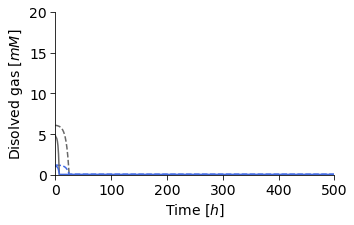

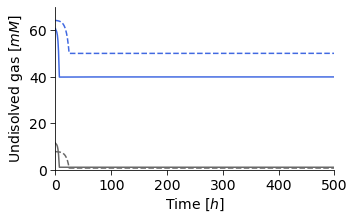

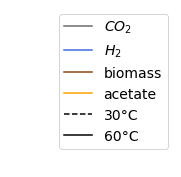

In [19]:
fig = plt.figure(figsize=(5,3))
plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t/3600,z_T1[:,2], color='dimgray', linestyle ="--")
plt.plot(t/3600,z_T1[:,3], color='royalblue', linestyle ="--")
plt.plot(t/3600,z_T2[:,2], color='dimgray', linestyle ="-")
plt.plot(t/3600,z_T2[:,3], color='royalblue', linestyle ="-")
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Disolved gas [$mM$]')
plt.axis([0, t_rt/3600, 0, 20])
plt.savefig('../Figures/Simulation/30_disolved')
plt.show()

fig = plt.figure(figsize=(5,3))
plt.plot(np.NaN, np.NaN, 'r')
plt.plot(np.NaN, np.NaN)
plt.plot(t/3600,z_T1[:,4], color='dimgray', linestyle ="--")
plt.plot(t/3600,z_T1[:,5], color='royalblue', linestyle ="--")
plt.plot(t/3600,z_T2[:,4], color='dimgray', linestyle ="-")
plt.plot(t/3600,z_T2[:,5], color='royalblue', linestyle ="-")
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Undisolved gas [$mM$]')
plt.axis([0, t_rt/3600, 0, 70])
plt.savefig('../Figures/Simulation/30_gas')
plt.show()

fig = plt.figure(figsize=(3,3))
plt.axis('off')
plt.plot(np.NaN, np.NaN, "dimgray")
plt.plot(np.NaN, np.NaN, 'royalblue')
plt.plot(np.NaN, np.NaN, 'saddlebrown')
plt.plot(np.NaN, np.NaN, 'orange')
plt.plot(np.NaN, np.NaN, "k--")
plt.plot(np.NaN, np.NaN, 'k-')
plt.legend([f'$CO_2$',f'$H_2$','biomass','acetate',"30°C","60°C"])
plt.savefig('../Figures/Simulation/Legend.svg')
plt.show()

In [20]:
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = "14"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 4

In [21]:
max(max(z_T1[:,0]),max(z_T2[:,0]))*24.6/1000

220.27875070761405

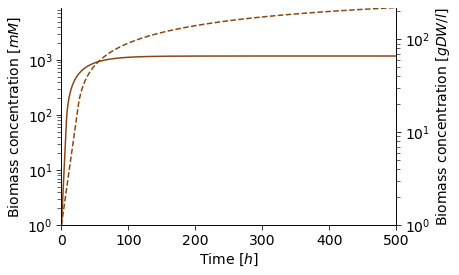

In [22]:
plt.plot(t/3600,(z_T1[:,0]), color='saddlebrown', linestyle ='--')
plt.plot(t/3600,(z_T2[:,0]), color='saddlebrown', linestyle ="-")
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Biomass concentration [$mM$]')
plt.axis([0, t_rt, inoc, max(max(z_T1[:,0]),max(z_T2[:,0]))])
plt.yscale('log')

ax2 = plt.twinx()
ax2.set_ylabel(r'Biomass concentration [$gDW/l$]')
ax2.axis([0, t_rt/3600, inoc, max(max(z_T1[:,0]),max(z_T2[:,0]))*24.6/1000])
plt.savefig('../Figures/Simulation/Biomass')
plt.yscale('log')
plt.show()

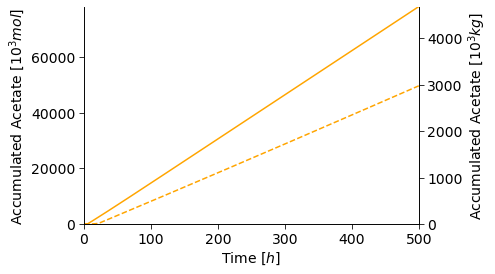

In [23]:
plt.plot(t/3600,z_T1[:,6]/10**3, color='orange', linestyle ="--")
plt.plot(t/3600,z_T2[:,6]/10**3, color='orange', linestyle ="-")
plt.xlabel(r'Time [$h$]')
plt.ylabel(r'Accumulated Acetate [$10^3 mol$]')
plt.axis([0, t_rt/3600, 0, max(max(z_T2[:,6]),max(z_T1[:,6]))/10**3])

ax2 = plt.twinx()
ax2.set_ylabel(r'Accumulated Acetate [$10^3 kg$]')
ax2.axis([0, t_rt/3600, 0, max(max(z_T2[:,6]),max(z_T1[:,6]))*0.06/1000])
plt.savefig('../Figures/Simulation/ProdAccumulation')

plt.show()

In [24]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = "14"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 4

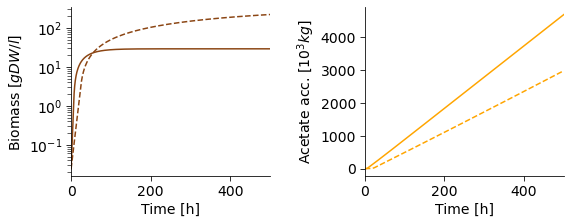

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, constrained_layout=True, figsize=(8,3))

axs[0].plot(t/3600,(z_T1[:,0])*24.6/1000, color='saddlebrown', linestyle ='--')
axs[0].plot(t/3600,(z_T2[:,0])*24.6/1000, color='saddlebrown', linestyle ='-')
axs[0].set_ylabel(r'Biomass [$gDW/l$]')
axs[0].set(yscale = 'log')

axs[1].plot(t/3600,z_T1[:,6]*0.06/1000, color='orange', linestyle ='--')
axs[1].plot(t/3600,z_T2[:,6]*0.06/1000, color='orange', linestyle ='-')
axs[1].set_ylabel(r'Acetate acc. [$10^3 kg$]')
#axs[1].legend(['30°C','60°C'])

for a in axs: a.set(
    #xticks = np.arange(0,t_rt/3600,t_rt/3600/3),
    xlabel = 'Time [h]', 
    xlim = [0, t_rt/3600])

Manually input a time after the steady state has been reached

In [26]:
T_SteadyState = t_rt-1

In [27]:
max(z_T1[:,0]),max(z_T2[:,0])

(8954.420760472116, 1179.8790025936582)

In [28]:
slopeT1, intercept = np.polyfit(t[t>T_SteadyState],z_T1[t>T_SteadyState,6],1)
slopeT2, intercept = np.polyfit(t[t>T_SteadyState],z_T2[t>T_SteadyState,6],1)
print(slopeT1, "mol/s")
print(slopeT2, "mol/s")

print(slopeT1/(V_L), "mol/s/m3")
print(slopeT2/(V_L), "mol/s/m3")

slopeT2/slopeT1

13.7789609011372 mol/s
21.680658563691043 mol/s
0.024366552645399355 mol/s/m3
0.03833982199887846 mol/s/m3


/Users/phivri/opt/anaconda3/envs/dFBACoCultivation/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.
/Users/phivri/opt/anaconda3/envs/dFBACoCultivation/lib/python3.6/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


1.5734610700507687

In [29]:
F_G*cG_h2_in_T1/slopeT1,F_G*cG_h2_in_T2/slopeT2,"[Pmol/Smol]"

(39.59463275194778, 23.750327156430927, '[Pmol/Smol]')